## 1. Pinhole camera model calibration

In [1]:
"""
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

pattern_size = (10, 7)

samples = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    res, corners = cv2.findChessboardCorners(frame, pattern_size)
    
    img_show = np.copy(frame)
    cv2.drawChessboardCorners(img_show, pattern_size, corners, res)
    cv2.putText(img_show, 'Samples captured: %d' % len(samples), (0, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
    cv2.imshow('chessboard', img_show)
    
    wait_time = 0 if res else 30
    k = cv2.waitKey(wait_time)
    
    if k == ord('s') and res:
        samples.append((cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), corners))
    elif k == 27:
        break

cap.release()
cv2.destroyAllWindows()

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

for i in range(len(samples)):
    img, corners = samples[i]
    corners = cv2.cornerSubPix(img, corners, (10, 10), (-1,-1), criteria)
    
pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

images, corners = zip(*samples)

pattern_points = [pattern_points]*len(corners)

rms, camera_matrix, dist_coefs, rvecs, tvecs = \
    cv2.calibrateCamera(pattern_points, corners, images[0].shape, None, None)

np.save('camera_mat.npy', camera_matrix)
np.save('dist_coefs.npy', dist_coefs)
"""
print()

## 2. Fisheye camera model calibration

In [2]:
"""
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

pattern_size = (10, 7)

samples = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    res, corners = cv2.findChessboardCorners(frame, pattern_size)
    
    img_show = np.copy(frame)
    cv2.drawChessboardCorners(img_show, pattern_size, corners, res)
    cv2.putText(img_show, 'Samples captured: %d' % len(samples), (0, 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
    cv2.imshow('chessboard', img_show)
    
    wait_time = 0 if res else 30
    k = cv2.waitKey(wait_time)
    
    if k == ord('s') and res:
        samples.append((cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), corners))
    elif k == 27:
        break

cap.release()
cv2.destroyAllWindows()

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)

for i in range(len(samples)):
    img, corners = samples[i]
    corners = cv2.cornerSubPix(img, corners, (10, 10), (-1,-1), criteria)
    
pattern_points = np.zeros((1, np.prod(pattern_size), 3), np.float32)
pattern_points[0, :, :2] = np.indices(pattern_size).T.reshape(-1, 2)

images, corners = zip(*samples)

pattern_points = [pattern_points]*len(corners)

print(len(pattern_points), pattern_points[0].shape, pattern_points[0].dtype)
print(len(corners), corners[0].shape, corners[0].dtype)

rms, camera_matrix, dist_coefs, rvecs, tvecs = \
    cv2.fisheye.calibrate(pattern_points, corners, images[0].shape, None, None)

np.save('camera_mat.npy', camera_matrix)
np.save('dist_coefs.npy', dist_coefs)
"""
print()

## 3. Stereo rig calibration: Extrinsic estimation

In [3]:
import cv2
import glob
import numpy as np

PATTERN_SIZE = (9, 6)
left_imgs = list(sorted(glob.glob('./data/stereo/case1/left*.png')))
right_imgs = list(sorted(glob.glob('./data/stereo/case1/right*.png')))
assert len(left_imgs) == len(right_imgs)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
left_pts, right_pts = [], []
img_size = None

for left_img_path, right_img_path in zip(left_imgs, right_imgs):
    left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)
    if img_size is None:
        img_size = (left_img.shape[1], left_img.shape[0])
    
    res_left, corners_left = cv2.findChessboardCorners(left_img, PATTERN_SIZE)
    res_right, corners_right = cv2.findChessboardCorners(right_img, PATTERN_SIZE)
    
    corners_left = cv2.cornerSubPix(left_img, corners_left, (10, 10), (-1,-1),
                                    criteria)
    corners_right = cv2.cornerSubPix(right_img, corners_right, (10, 10), (-1,-1), 
                                     criteria)
    
    left_pts.append(corners_left)
    right_pts.append(corners_right)
    
pattern_points = np.zeros((np.prod(PATTERN_SIZE), 3), np.float32)
pattern_points[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
pattern_points = [pattern_points] * len(left_imgs)

err, Kl, Dl, Kr, Dr, R, T, E, F = cv2.stereoCalibrate(
    pattern_points, left_pts, right_pts, None, None, None, None, img_size, flags=0)

print('Left camera:')
print(Kl)
print('\nLeft camera distortion:')
print(Dl)
print('\nRight camera:')
print(Kr)
print('\nRight camera distortion:')
print(Dr)
print('\nRotation matrix:')
print(R)
print('\nTranslation:')
print(T)

np.save('stereo.npy', {'Kl': Kl, 'Dl': Dl, 'Kr': Kr, 'Dr': Dr, 'R': R, 'T': T, 'E': E, 'F': F, 
                       'img_size': img_size, 'left_pts': left_pts, 'right_pts': right_pts})

Left camera:
[[534.366832     0.         341.45686517]
 [  0.         534.29617933 235.72519985]
 [  0.           0.           1.        ]]

Left camera distortion:
[[-2.79471016e-01  4.71885102e-02  1.39511338e-03 -1.64159511e-04
   7.01712913e-02]]

Right camera:
[[537.88730672   0.         327.29925215]
 [  0.         537.43064616 250.10023263]
 [  0.           0.           1.        ]]

Right camera distortion:
[[-0.28990693  0.12537795 -0.00040656  0.00053461 -0.03844603]]

Rotation matrix:
[[ 0.99998995  0.00355598  0.00273006]
 [-0.00354058  0.99997791 -0.00562462]
 [-0.00275     0.00561489  0.99998046]]

Translation:
[[-3.33161157]
 [ 0.03706723]
 [-0.00420823]]


## 4. Distorting and undistorting points

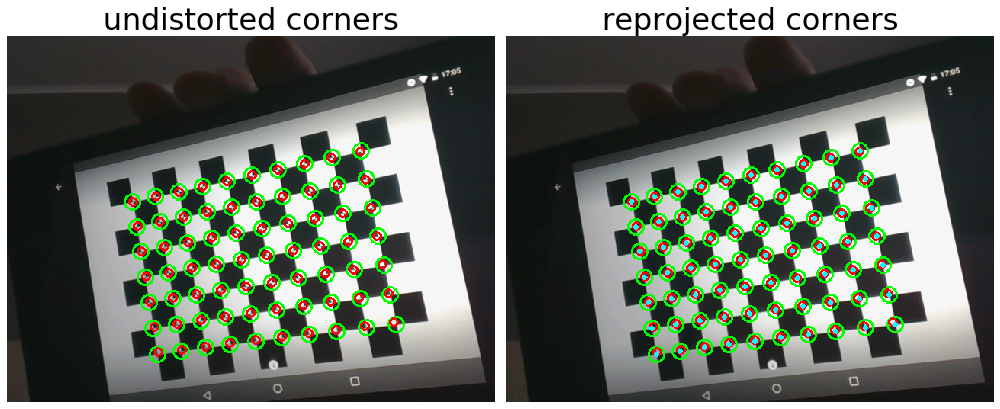

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

camera_matrix = np.load('./data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('./data/pinhole_calib/dist_coefs.npy')

img = cv2.imread('./data/pinhole_calib/img_00.png')
pattern_size = (10, 7)
res, corners = cv2.findChessboardCorners(img, pattern_size)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
corners = cv2.cornerSubPix(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 
                           corners, (10, 10), (-1,-1), criteria)

h_corners = cv2.undistortPoints(corners, camera_matrix, dist_coefs)
h_corners = np.c_[h_corners.squeeze(), np.ones(len(h_corners))]

img_pts, _ = cv2.projectPoints(h_corners, (0, 0, 0), (0, 0, 0), camera_matrix, None)

for c in corners:
    cv2.circle(img, tuple(c[0]), 10, (0, 255, 0), 2)

for c in img_pts.squeeze().astype(np.float32):
    cv2.circle(img, tuple(c), 5, (0, 0, 255), 2)


image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.axis('off')
plt.title('undistorted corners', size=30)
plt.xticks([]), plt.yticks([])
plt.imshow(image)

img_pts, _ = cv2.projectPoints(h_corners, (0, 0, 0), (0, 0, 0), camera_matrix, dist_coefs)

for c in img_pts.squeeze().astype(np.float32):
    cv2.circle(img, tuple(c), 2, (255, 255, 0), 2)

image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(122)
plt.axis('off')
plt.title('reprojected corners', size=30)
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 5. Removing lens distortion effects from image

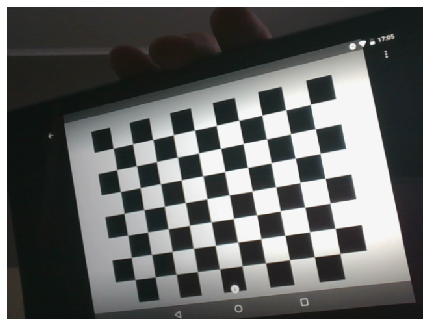

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

camera_matrix = np.load('./data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('./data/pinhole_calib/dist_coefs.npy')
img = cv2.imread('./data/pinhole_calib/img_00.png')

ud_img = cv2.undistort(img, camera_matrix, dist_coefs)


opt_cam_mat, valid_roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, img.shape[:2][::-1], 0)

ud_img = cv2.undistort(img, camera_matrix, dist_coefs, None, opt_cam_mat)

image = cv2.cvtColor(ud_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 6. Restoring 3D point from two observation via triangulation

In [6]:
import cv2
import numpy as np

P1 = np.eye(3, 4, dtype=np.float32)
P2 = np.eye(3, 4, dtype=np.float32)
P2[0, 3] = -1

N = 5
points3d = np.empty((4, N), np.float32)
points3d[:3, :] = np.random.randn(3, N)
points3d[3, :] = 1

points1 = P1 @ points3d
points1 = points1[:2, :] / points1[2, :]
points1[:2, :] += np.random.randn(2, N) * 1e-2

points2 = P2 @ points3d
points2 = points2[:2, :] / points2[2, :]
points2[:2, :] += np.random.randn(2, N) * 1e-2

points3d_reconstr = cv2.triangulatePoints(P1, P2, points1, points2)
points3d_reconstr /= points3d_reconstr[3, :]

print('Original points')
print(points3d[:3].T)
print('\nReconstructed points')
print(points3d_reconstr[:3].T)

Original points
[[ 0.42396295 -0.8459795  -0.37933043]
 [ 0.03784994 -0.56582916 -1.2028415 ]
 [-0.9735244   1.6606045  -0.11233863]
 [-0.01099545 -0.40786293 -0.29306832]
 [ 0.55895317  0.36921167  1.093342  ]]

Reconstructed points
[[ 0.423895   -0.8546879  -0.38064253]
 [ 0.03321763 -0.56984234 -1.2042975 ]
 [-0.974844    1.662974   -0.11244833]
 [-0.0094652  -0.40819594 -0.29333165]
 [ 0.55588377  0.38353968  1.1154792 ]]


## 7. Find relative camera-object pose via PnP algorithm

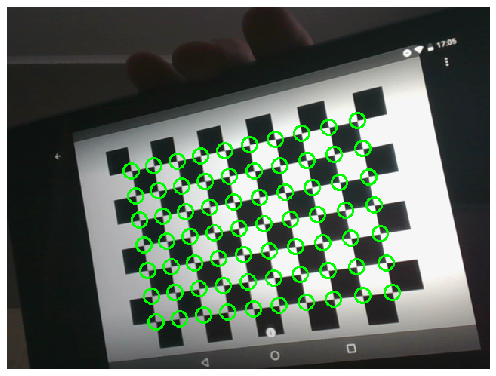

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

camera_matrix = np.load('./data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('./data/pinhole_calib/dist_coefs.npy')
img = cv2.imread('./data/pinhole_calib/img_00.png')

pattern_size = (10, 7)
res, corners = cv2.findChessboardCorners(img, pattern_size)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
corners = cv2.cornerSubPix(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 
                           corners, (10, 10), (-1,-1), criteria)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)

ret, rvec, tvec = cv2.solvePnP(pattern_points, corners, camera_matrix, dist_coefs, 
                               None, None, False, cv2.SOLVEPNP_ITERATIVE)

img_points, _ = cv2.projectPoints(pattern_points, rvec, tvec, camera_matrix, dist_coefs)

for c in img_points.squeeze():
    cv2.circle(img, tuple(c), 10, (0, 255, 0), 2)

image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 8. Aligning two views via stereo rectification

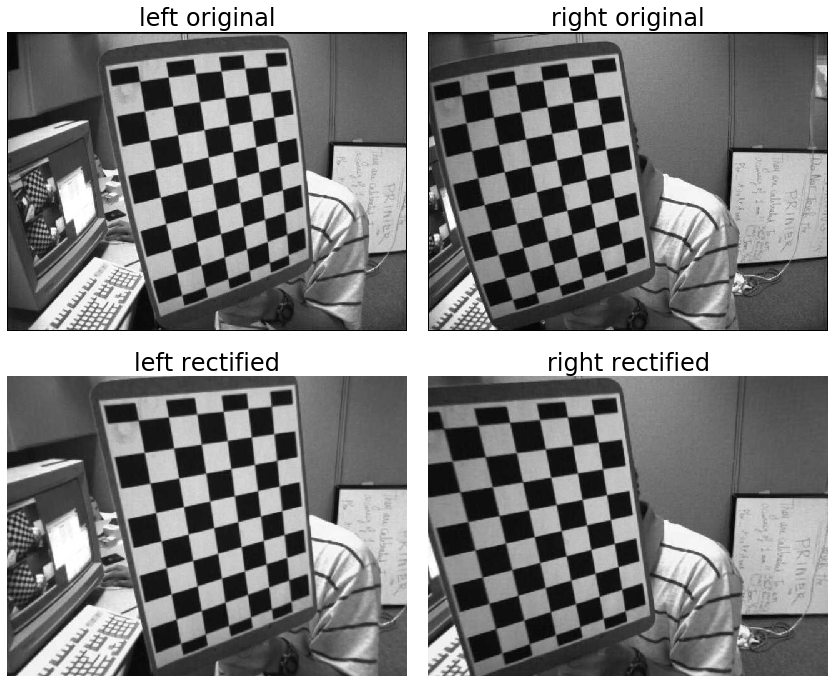

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

data = np.load('./data/stereo/case1/stereo.npy').item()
Kl, Dl, Kr, Dr, R, T, img_size = data['Kl'], data['Dl'], data['Kr'], data['Dr'], \
                                 data['R'], data['T'], data['img_size']

left_img = cv2.imread('./data/stereo/case1/left14.png')
right_img = cv2.imread('./data/stereo/case1/right14.png')

R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(Kl, Dl, Kr, Dr, img_size, R, T)

xmap1, ymap1 = cv2.initUndistortRectifyMap(Kl, Dl, R1, Kl, img_size, cv2.CV_32FC1)
xmap2, ymap2 = cv2.initUndistortRectifyMap(Kr, Dr, R2, Kr, img_size, cv2.CV_32FC1)

left_img_rectified = cv2.remap(left_img, xmap1, ymap1, cv2.INTER_LINEAR)
right_img_rectified = cv2.remap(right_img, xmap2, ymap2, cv2.INTER_LINEAR)

plt.figure(0, figsize=(12,10))
plt.subplot(221)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('left original')
plt.imshow(left_img, cmap='gray')
plt.subplot(222)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('right original')
plt.imshow(right_img, cmap='gray')
plt.subplot(223)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('left rectified')
plt.imshow(left_img_rectified, cmap='gray')
plt.subplot(224)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('right rectified')
plt.imshow(right_img_rectified, cmap='gray')
plt.tight_layout()
plt.show()

## 9. Epipolar geometry: Computing fundamental and essential matrices

In [9]:
import cv2
import numpy as np

data = np.load('./data/stereo/case1/stereo.npy').item()
Kl, Kr, Dl, Dr, left_pts, right_pts, E_from_stereo, F_from_stereo = \
    data['Kl'], data['Kr'], data['Dl'], data['Dr'], \
    data['left_pts'], data['right_pts'], data['E'], data['F']

left_pts = np.vstack(left_pts)
right_pts = np.vstack(right_pts)

left_pts = cv2.undistortPoints(left_pts, Kl, Dl, P=Kl)
right_pts = cv2.undistortPoints(right_pts, Kr, Dr, P=Kr)

F, mask = cv2.findFundamentalMat(left_pts, right_pts, cv2.FM_LMEDS)

E = Kr.T @ F @ Kl

print('Fundamental matrix:')
print(F)
print('\nEssential matrix:')
print(E)

Fundamental matrix:
[[ 1.60938825e-08 -2.23906409e-06 -2.53850603e-04]
 [ 2.97226703e-06 -2.38236386e-07 -7.70276666e-02]
 [-2.55190056e-04  7.69760820e-02  1.00000000e+00]]

Essential matrix:
[[ 4.62585055e-03 -6.43487140e-01 -4.17486092e-01]
 [ 8.53590806e-01 -6.84088948e-02 -4.08817705e+01]
 [ 2.63679084e-01  4.07046349e+01 -2.20825664e-01]]


## 10. Essential matrix decomposition into rotation and translation

In [10]:
import cv2
import numpy as np

data = np.load('./data/stereo/case1/stereo.npy').item()
E = data['E']

R1, R2, T = cv2.decomposeEssentialMat(E)

print('Rotation 1:')
print(R1)
print('\nRotation 2:')
print(R2)
print('\nTranslation:')
print(T)

Rotation 1:
[[ 0.99981105 -0.01867927  0.00538031]
 [-0.01870903 -0.99980965  0.00553437]
 [ 0.00527591 -0.00563399 -0.99997021]]

Rotation 2:
[[ 0.99998995  0.00355598  0.00273003]
 [-0.00354058  0.99997791 -0.00562461]
 [-0.00274997  0.00561489  0.99998046]]

Translation:
[[ 0.99993732]
 [-0.01112522]
 [ 0.00126302]]


## 11. Estimating disparity maps for stereo images

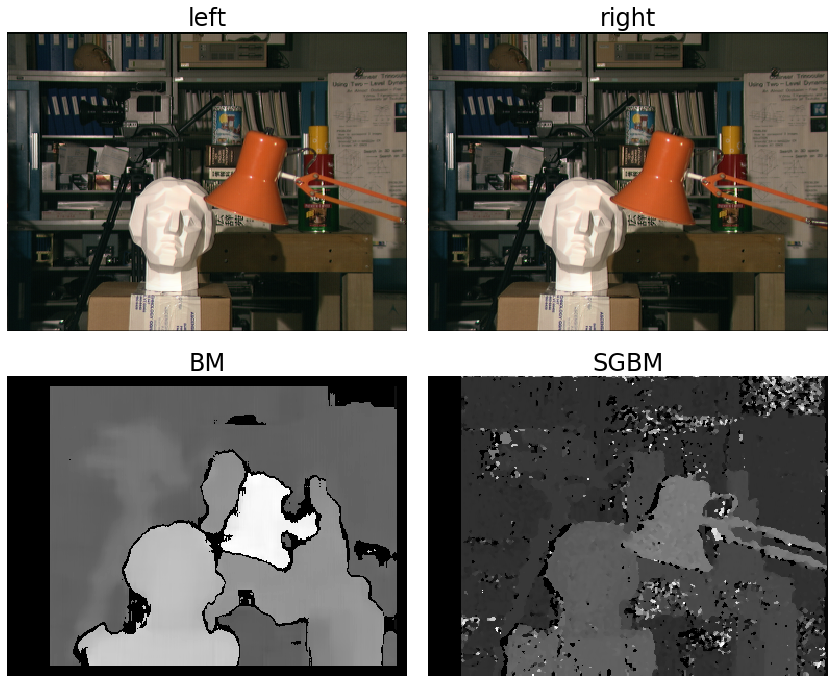

In [11]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

left_img = cv2.imread('./data/stereo/left.png')
right_img = cv2.imread('./data/stereo/right.png')

stereo_bm = cv2.StereoBM_create(32)
dispmap_bm = stereo_bm.compute(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY), 
                               cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY))

stereo_sgbm = cv2.StereoSGBM_create(0, 32)
dispmap_sgbm = stereo_sgbm.compute(left_img, right_img)

plt.figure(figsize=(12,10))
plt.subplot(221)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('left')
plt.imshow(left_img[:,:,[2,1,0]])
plt.subplot(222)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('right')
plt.imshow(right_img[:,:,[2,1,0]])
plt.subplot(223)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('BM')
plt.imshow(dispmap_bm, cmap='gray')
plt.subplot(224)
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.title('SGBM')
plt.imshow(dispmap_sgbm, cmap='gray')
plt.tight_layout()
plt.show()

## 12. Special case of 2-view geometry: Estimating homography transformation

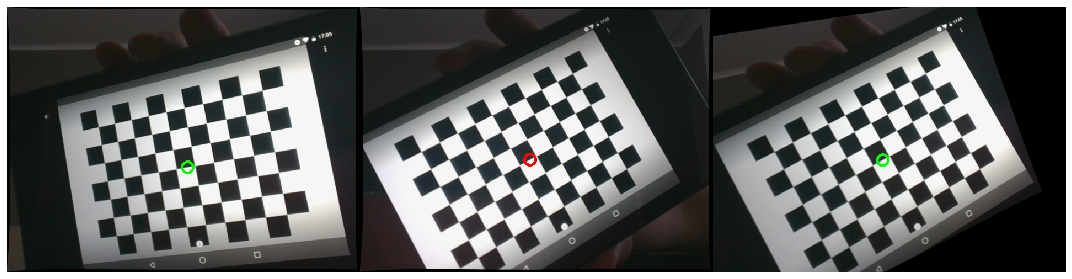

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

camera_matrix = np.load('./data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('./data/pinhole_calib/dist_coefs.npy')
img_0 = cv2.imread('./data/pinhole_calib/img_00.png')
img_1 = cv2.imread('./data/pinhole_calib/img_10.png')

img_0 = cv2.undistort(img_0, camera_matrix, dist_coefs)
img_1 = cv2.undistort(img_1, camera_matrix, dist_coefs)

pattern_size = (10, 7)
res_0, corners_0 = cv2.findChessboardCorners(img_0, pattern_size)
res_1, corners_1 = cv2.findChessboardCorners(img_1, pattern_size)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
corners_0 = cv2.cornerSubPix(cv2.cvtColor(img_0, cv2.COLOR_BGR2GRAY), 
                           corners_0, (10, 10), (-1,-1), criteria)
corners_1 = cv2.cornerSubPix(cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY), 
                           corners_1, (10, 10), (-1,-1), criteria)

H, mask = cv2.findHomography(corners_0, corners_1)

center_0 = np.mean(corners_0.squeeze(), 0)
center_0 = np.r_[center_0, 1]
center_1 = H @ center_0
center_1 = (center_1 / center_1[2]).astype(np.float32)

img_0 = cv2.circle(img_0, tuple(center_0[:2]), 10, (0, 255, 0), 3)
img_1 = cv2.circle(img_1, tuple(center_1[:2]), 10, (0, 0, 255), 3)

img_0_warped = cv2.warpPerspective(img_0, H, img_0.shape[:2][::-1])

image = cv2.cvtColor(np.hstack((img_0, img_1, img_0_warped)), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.axis('off')
plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.imshow(image)
plt.show()

## 13. Planar scene: Decomposing homography into rotation and translation

In [13]:
import cv2
import numpy as np

camera_matrix = np.load('./data/pinhole_calib/camera_mat.npy')
dist_coefs = np.load('./data/pinhole_calib/dist_coefs.npy')
img_0 = cv2.imread('./data/pinhole_calib/img_00.png')
img_0 = cv2.undistort(img_0, camera_matrix, dist_coefs)
img_1 = cv2.imread('./data/pinhole_calib/img_10.png')
img_1 = cv2.undistort(img_1, camera_matrix, dist_coefs)

pattern_size = (10, 7)
res_0, corners_0 = cv2.findChessboardCorners(img_0, pattern_size)
res_1, corners_1 = cv2.findChessboardCorners(img_1, pattern_size)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
corners_0 = cv2.cornerSubPix(cv2.cvtColor(img_0, cv2.COLOR_BGR2GRAY), 
                           corners_0, (10, 10), (-1,-1), criteria)
corners_1 = cv2.cornerSubPix(cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY), 
                           corners_1, (10, 10), (-1,-1), criteria)

H, mask = cv2.findHomography(corners_0, corners_1)

ret, rmats, tvecs, normals = cv2.decomposeHomographyMat(H, camera_matrix)
#print(ret)

## 14. Rotational camera case: Estimating camera rotation from homography

In [14]:
import cv2
import numpy as np


K = np.array([[560,0,320],[0,560,240],[0,0,1]],dtype=np.float32)
rvec = np.array([0.1, 0.2, 0.3], np.float32)
R, _ = cv2.Rodrigues(rvec)

H = K @ R @ np.linalg.inv(K)
H /= H[2, 2]

H += np.random.randn(3,3)*0.0001
np.save('rotational_homography.npy', {'H': H, 'K': K})



data = np.load('./data/rotational_homography.npy').item()
H, K = data['H'], data['K']

H_ = np.linalg.inv(K) @ H @ K

w, u, vt = cv2.SVDecomp(H_)
R = u @ vt
if cv2.determinant(R) < 0:
    R *= 1

rvec = cv2.Rodrigues(R)[0]

print('Rotation vector:')
print(rvec)

Rotation vector:
[[0.12439561]
 [0.22688714]
 [0.3264132 ]]
